# SUMMARY

## [Import libraries and files](#ch0)

# [1 - Feature selection](#ch1)

# [2 - Clean Outliers](#ch2)

# [3 - Imputation](#ch3)


## [Export](#ch99)

<a id="ch0"></a>
## Import libraries and files

In [77]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
from sklearn.model_selection import GridSearchCV

In [78]:
raw = pd.read_csv('/Users/alexandremonod/Python/OC ML/p2/csv/products.csv', sep='\t')
path_figures = "/Users/alexandremonod/Python/OC ML/p2/figures" 

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<a id="ch1"></a>
# 1 - Feature selection

In [79]:
# Check data

print(len(list(raw.columns)))
print(raw.shape[0])
raw.describe(include='all')

162
320772


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,3.207490e+05,320749,320770,3.207690e+05,320763,3.207720e+05,320772,303010,52795,104819,...,49.000000,3036.000000,165.000000,948.000000,0.0,268.000000,221210.000000,221210.000000,0.0,0.0
unique,3.206380e+05,320749,3535,1.896360e+05,189568,1.806390e+05,180495,221347,38584,13826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,7.222001e+10,http://world-fr.openfoodfacts.org/produit/0009...,usda-ndb-import,1.489077e+09,2017-03-09T10:37:09Z,1.439142e+09,2015-08-09T17:35:42Z,Ice Cream,Pâtes alimentaires au blé dur de qualité supér...,500 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2.000000e+00,1,169868,2.000000e+01,20,3.300000e+01,33,410,201,4669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.047841,31.967918,3.753028,18.757932,NaN,425.211439,9.055903,9.183589,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,8.000000,6.000000,NaN,0.000000,-15.000000,-15.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.300000,0.000000,12.000000,32.000000,NaN,98.750000,1.000000,1.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.200000,23.000000,15.000000,50.000000,NaN,195.750000,10.000000,9.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.400000,51.000000,15.000000,64.250000,NaN,383.200000,16.000000,16.000000,NaN,NaN


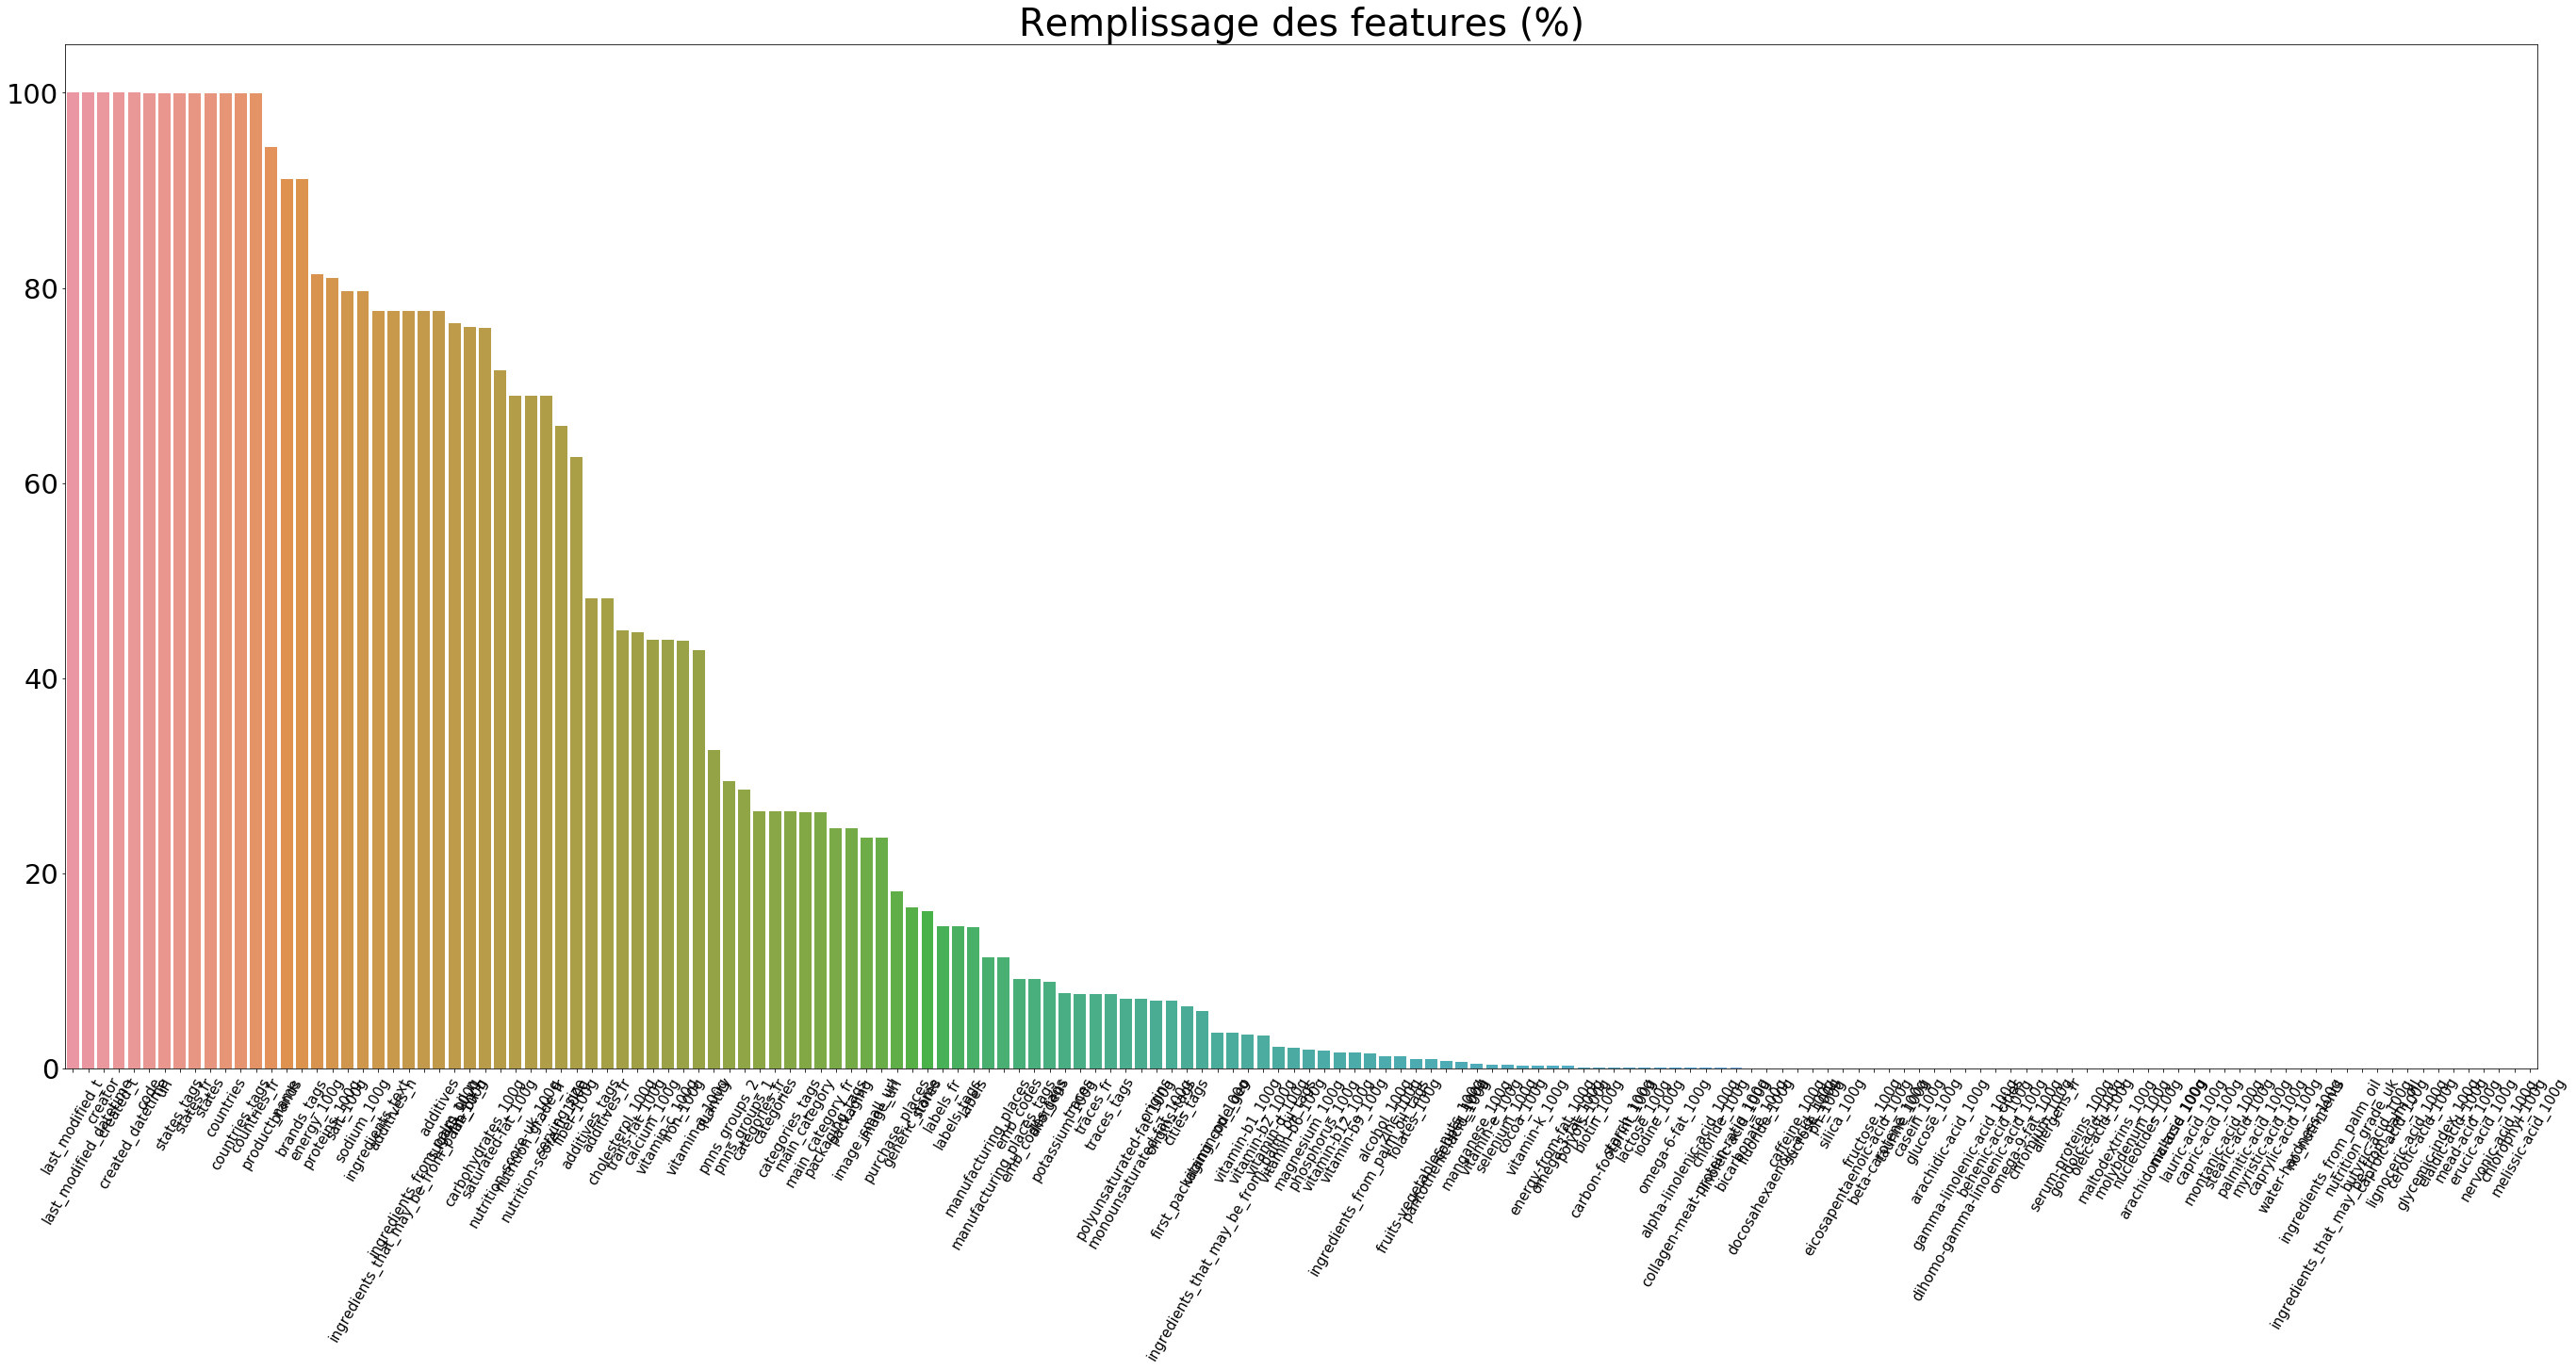

In [80]:
# Columns, sorted by their filling

# Plot columns with their number of values

fig, ax = plt.subplots(1,1, figsize=(47,20))

raw_sorted = raw.count().sort_values(ascending=False) / raw.shape[0] * 100
sns.barplot(x=raw_sorted.index, y=raw_sorted, orient="v")
plt.xticks(fontsize=15, rotation=60)
plt.yticks(fontsize=29)
plt.title("Remplissage des features (%)", fontsize=40)
plt.savefig(f"{path_figures}/_all_features")

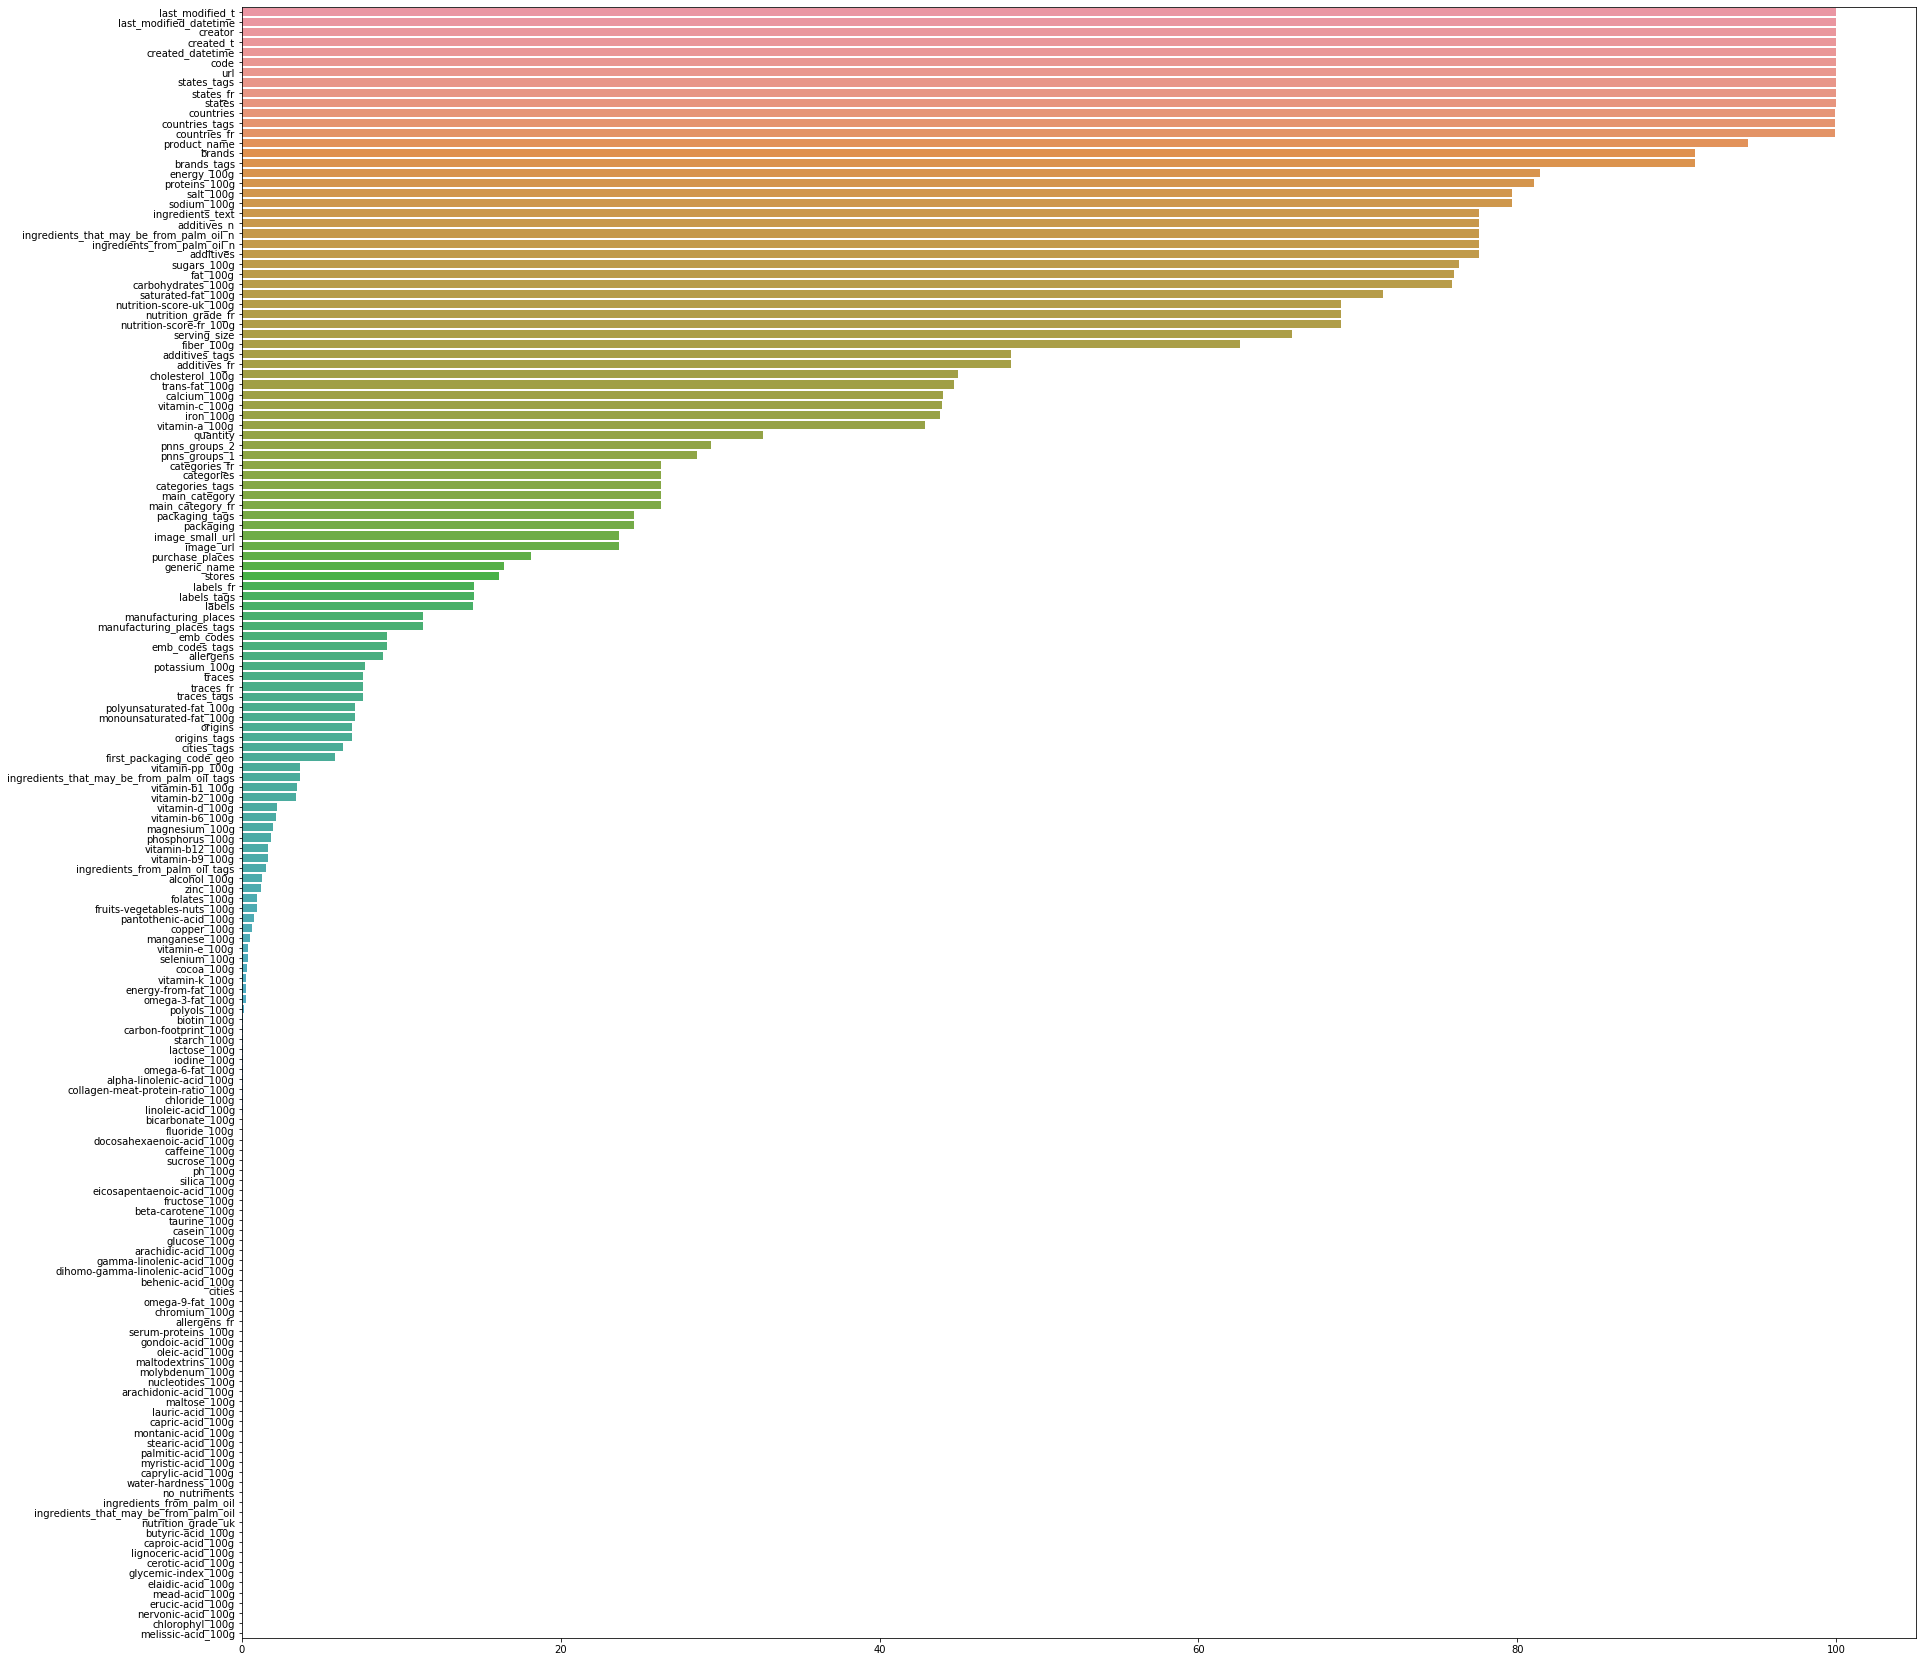

In [81]:
# Columns, sorted by their filling

# Plot columns with their number of values

fig, ax = plt.subplots(1,1, figsize=(30,30))

raw_sorted = raw.count().sort_values(ascending=False) / raw.shape[0] * 100
sns.barplot(y=raw_sorted.index, x=raw_sorted, orient="h")
plt.savefig(f"{path_figures}/_all_features")

High disparity between features.  
Only a quarter can be used.

In [82]:
# Drop the many very useless columns

# Drop first technical columns
raw_dropped = raw.drop(columns=raw.columns[0:7])

# Drop tags columns
raw_dropped = raw[[x for x in raw if not x.endswith("tags")]]

# Drop columns with images
raw_dropped = raw_dropped[[x for x in raw_dropped if not x.startswith("image")]]

# Drop columns with insufficient values
threshold_columns = raw.shape[0] / 2  # Drop columns with 50% values or less
raw_dropped = raw_dropped.drop(columns=raw_dropped.columns[raw_dropped.count() < threshold_columns])

In [83]:
# When duplicates, check count of English column and French column
fr_string = "_fr"
columns = raw[[x for x in raw_dropped if x.endswith(fr_string)]].columns.tolist()
eng_columns = [i.rstrip("_fr") for i in columns]
eng_columns.remove('nutrition_grade') # Already dropped, not enough values
columns.extend(eng_columns)

# Add manually nutrition score columns
columns.extend(["nutrition-score-uk_100g", "nutrition-score-fr_100g"])


raw_fr_eng = raw_dropped[columns]
raw_fr_eng.count().sort_values()

nutrition_grade_fr         221210
nutrition-score-uk_100g    221210
nutrition-score-fr_100g    221210
countries_fr               320492
countries                  320492
states_fr                  320726
states                     320726
dtype: int64

Counts are the same.  
Column "nutrition_grade" in English doesn't exist anymore : it was dropped because not enough values.

In [84]:
raw_dropped = raw_dropped.drop(columns=eng_columns, axis=1)

In [85]:
# Select a category column
df_categories = raw[["pnns_groups_1", "pnns_groups_2", "main_category_fr"]]
df_categories.info()
[len(df_categories[i].unique()) for i in df_categories.columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   pnns_groups_1     91513 non-null  object
 1   pnns_groups_2     94491 non-null  object
 2   main_category_fr  84366 non-null  object
dtypes: object(3)
memory usage: 7.3+ MB


[15, 43, 3544]

Pnns_groups_2 has more values, let's keep it.

In [86]:
# Second drop : identify and keep useful columns

useful_columns = list(raw_dropped.drop(columns=[
    "code", 'url', "creator", "created_t", "created_datetime"
    ,"last_modified_t", "last_modified_datetime", "ingredients_text"
    , "states_fr", "additives"
    , "serving_size", "ingredients_from_palm_oil_n"
    , "ingredients_that_may_be_from_palm_oil_n"
    , "nutrition-score-uk_100g"]
    , axis=1).columns)

useful_columns.extend([
    "pnns_groups_2", "labels_fr"
    ])              # Keep labels because no need to have many values
                    # Keep pnns_groups_2 because useful then ????
data = raw[useful_columns]

In [87]:
# Missing values for the category are Unknown values
data.pnns_groups_2.replace(np.nan, "unknown", inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4569: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


<a id="ch2"></a>
# 2 - Clean outliers

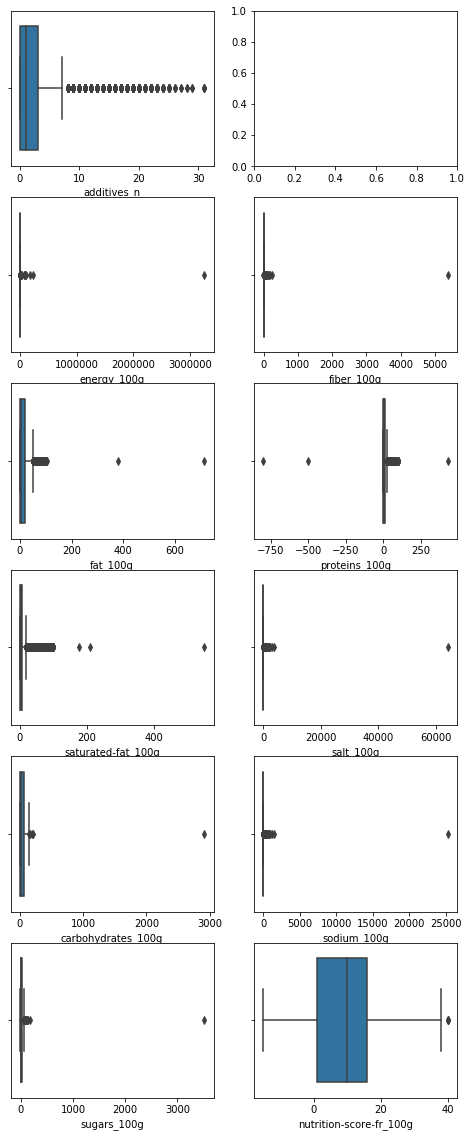

In [88]:
# First plot numeric features

# Select only numeric columns
data_numeric = data.select_dtypes(include=float)

nb_colonnes_data = len(data_numeric.columns)
fig, axes = plt.subplots(int((nb_colonnes_data/2)+1), 2, figsize=(8,20))

[sns.boxplot(data=data_numeric, x=data_numeric[col], ax=axes[
        np.where(index > (nb_colonnes_data/2), index-5, index)
        , np.where(index < (nb_colonnes_data/2), 0, 1)])
        for index, col in enumerate(data_numeric.columns)]
plt.savefig(f"{path_figures}/outliers")

Lots of outliers.  
Only two features ok : additives & nutrition_score.

In [89]:
columns_100g = data[[x for x in data if x.endswith("100g")]].columns.tolist()

# Drop negative values
data[columns_100g] = np.where(data[columns_100g] < 0, np.nan, data[columns_100g])
columns_100g.remove("energy_100g")

# Drop absurd values (values > 100g)
data[columns_100g] = np.where(data[columns_100g] > 100, np.nan, data[columns_100g])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [90]:
# Normal rates per category

max_fiber = 50               # https://www.myfooddata.com/articles/foods-high-in-dietary-fiber.php
max_proteins = 50            # https://www.myfooddata.com/articles/foods-highest-in-protein.php  
max_salt = 3                 # https://www.bhf.org.uk/informationsupport/support/healthy-living/healthy-eating/salt
max_sodium = 1.2
max_energy = 15000           # https://informationsnutritionnelles.fr/energie-kilojoules 

data.fiber_100g = np.where(data.fiber_100g > max_fiber, np.nan, data.fiber_100g)
data.proteins_100g = np.where(data.proteins_100g > max_proteins, np.nan, data.proteins_100g)
data.salt_100g = np.where(data.salt_100g > max_salt, np.nan, data.salt_100g)
data.sodium_100g = np.where(data.sodium_100g > max_sodium, np.nan, data.sodium_100g)
data.energy_100g = np.where(data.energy_100g > max_energy, np.nan, data.energy_100g)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

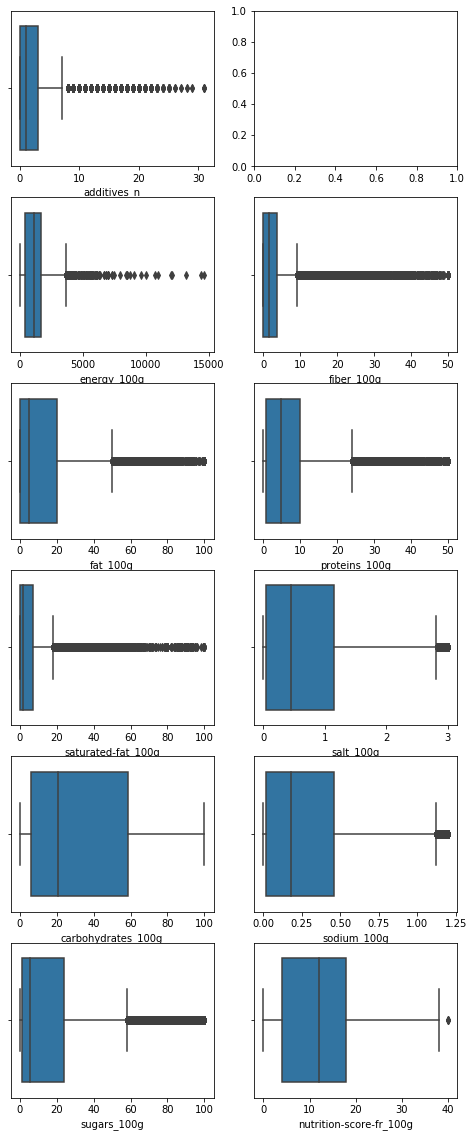

In [91]:
# Second plot numeric features

data_numeric = data.select_dtypes(include=float)

fig, axes = plt.subplots(int((nb_colonnes_data/2)+1), 2, figsize=(8,20))

[sns.boxplot(data=data_numeric, x=data_numeric[col], ax=axes[
        np.where(index > (nb_colonnes_data/2), index-5, index)
        , np.where(index < (nb_colonnes_data/2), 0, 1)])
        for index, col in enumerate(data_numeric.columns)]
plt.savefig(f"{path_figures}/outliers_cleaned")

Better.

<a id="ch3"></a>
# 3 - Imputation

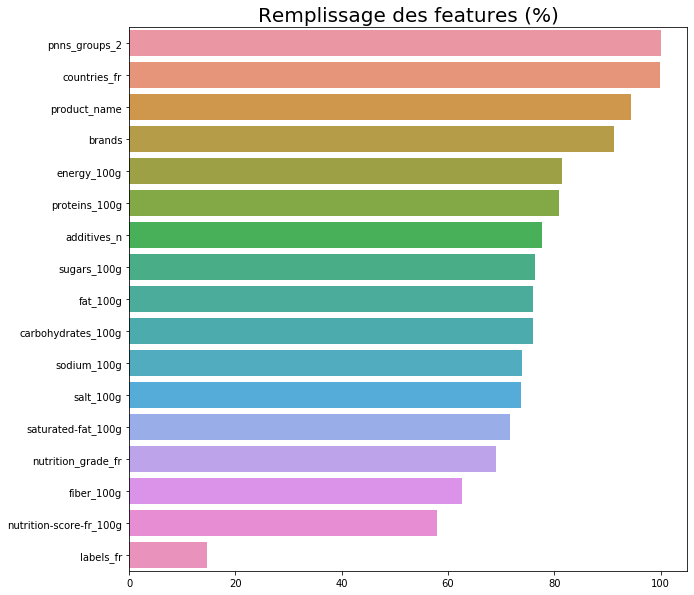

In [92]:
# Graphe taux de remplissage

fig, ax = plt.subplots(1,1, figsize=(10,10))

data_sorted = data.count().sort_values(ascending=False) / data.shape[0] * 100
sns.barplot(y=data_sorted.index, x=data_sorted, orient="h")
plt.title("Remplissage des features (%)", fontsize=20)
plt.savefig(f"{path_figures}/imputation_no")

Many features filled > 70% --> imputation by median  
Several features between 50 - 70% --> imputation KNN

### 1 - Median

In [93]:
# Nutriscore is an aggregate column : can't impute it with median
# But OK to impute other values

# Select columns with 30% max missing values
col_imputation = []
max_count = data.product_name.count() * 70 / 100
[col_imputation.append(i) if data[i].count() > max_count else '' for i in data[columns_100g].columns]

# Impute with median and where pnns is the same
data[col_imputation] = data[col_imputation].fillna(data.groupby('pnns_groups_2')[col_imputation].transform('median'))

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


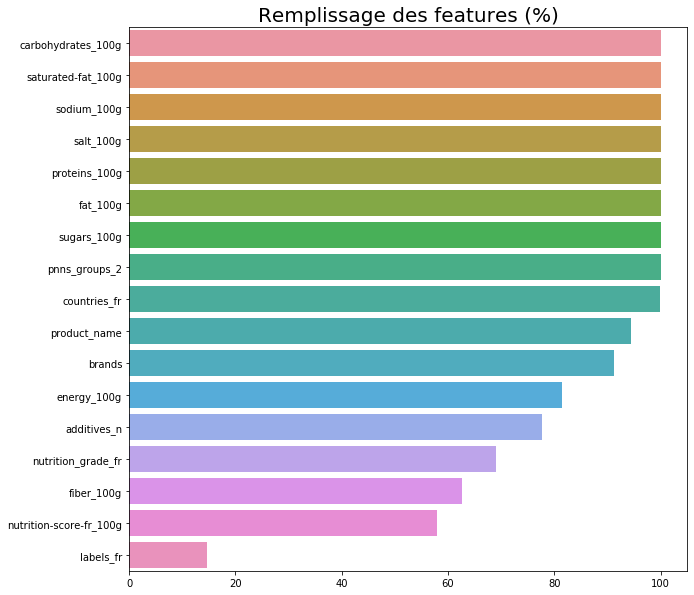

In [94]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

data_sorted = data.count().sort_values(ascending=False) / data.shape[0] * 100
sns.barplot(y=data_sorted.index, x=data_sorted, orient="h")
plt.title("Remplissage des features (%)", fontsize=20)
plt.savefig(f"{path_figures}/imputation_median")

Imputation median ok.

### 2 - KNN Regressor

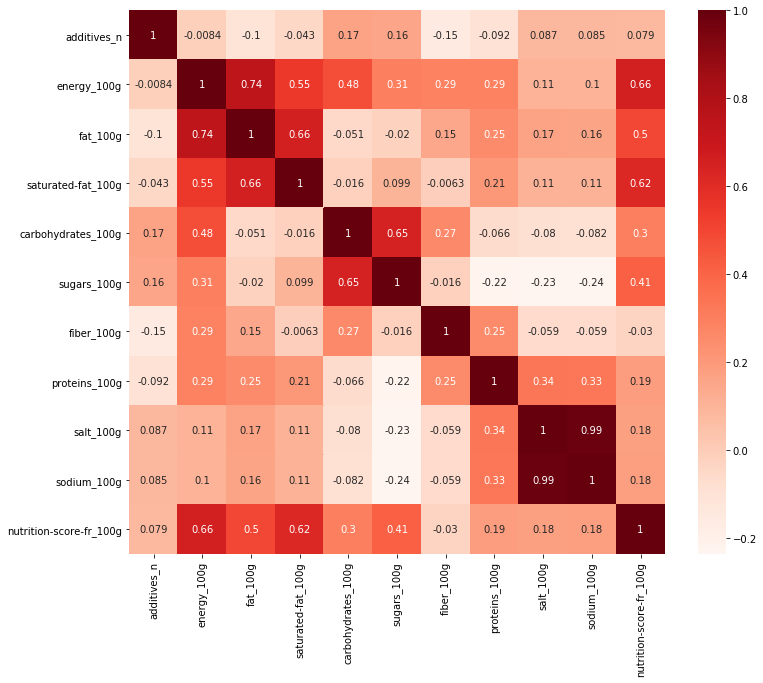

energy_100g                0.657851
fat_100g                   0.496364
saturated-fat_100g         0.618897
carbohydrates_100g         0.304679
sugars_100g                0.413751
nutrition-score-fr_100g    1.000000
Name: nutrition-score-fr_100g, dtype: float64

In [95]:
# When missing data > 30% : use KNN regressor

# Imputation nutrition score
# Regression matrix : check most linked features to nutriscore

plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig(f"{path_figures}/corr")

plt.show()

# Filter most correlated values

#Correlation with output variable
cor_target = abs(cor["nutrition-score-fr_100g"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.3]
relevant_features

In [96]:
# Create train and test set

knn_dataset = data[list(relevant_features.index)].dropna()

train , test = train_test_split(knn_dataset, test_size = 0.3)

x_train = train.drop('nutrition-score-fr_100g', axis=1)
y_train = train['nutrition-score-fr_100g']

x_test = test.drop('nutrition-score-fr_100g', axis = 1)
y_test = test['nutrition-score-fr_100g']

# Preprocessing – Scaling the features

scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

RMSE value for k=  1 is: 3.879524057254667
RMSE value for k=  2 is: 3.4983261149241645
RMSE value for k=  3 is: 3.3513838354715557
RMSE value for k=  4 is: 3.2940357974815813
RMSE value for k=  5 is: 3.2725120046081346
RMSE value for k=  6 is: 3.2576266521913912
RMSE value for k=  7 is: 3.2511109932873046
RMSE value for k=  8 is: 3.250167937137901
RMSE value for k=  9 is: 3.2556659871602265
RMSE value for k=  10 is: 3.254357524414838
RMSE value for k=  11 is: 3.253115153571776
RMSE value for k=  12 is: 3.2577850513652518
RMSE value for k=  13 is: 3.2627999008287443
RMSE value for k=  14 is: 3.2688283456856606
RMSE value for k=  15 is: 3.2687516641204715
RMSE value for k=  16 is: 3.271087897659863
RMSE value for k=  17 is: 3.275515392780241
RMSE value for k=  18 is: 3.2780368594334792
RMSE value for k=  19 is: 3.2826438015093435
RMSE value for k=  20 is: 3.2887640656327197


7

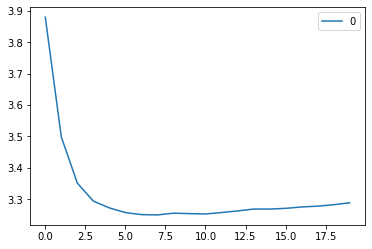

In [97]:
# Error rate for different k values

rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()
plt.savefig(f"{path_figures}/elbow")

# With GridSearch

params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(x_train,y_train)
k = model.best_params_.get('n_neighbors')
k

Peak between 5 and 10. Hard to determine precisely : let's use GridSearch's k.

In [98]:
# Make prediction with definite K

model = neighbors.KNeighborsRegressor(n_neighbors = k)
model.fit(x_train, y_train)  #fit the model

data_pred = data[list(relevant_features.index)][data["nutrition-score-fr_100g"].isnull()].drop("nutrition-score-fr_100g", axis=1)
pred=model.predict(data_pred) #make prediction on test set

data_pred["nutrition-score-fr_100g"] = pred
data_temp = pd.concat([data_pred, knn_dataset])
data["nutrition-score-fr_100g"] = data_temp["nutrition-score-fr_100g"]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Imputation nutrition_grade
# Source : https://quoidansmonassiette.fr/comment-est-calcule-le-nutri-score-logo-nutritionnel/

# Drinks
drinks = ["Non-sugared beverages"
            , "Sweetened beverages", "Alcoholic beverages"
            , "Artificially sweetened beverages", "Fruit juices"
            , "Fruit nectars", 
            ]

data.loc[(data.nutrition_grade_fr.isnull()) 
                & (data["nutrition-score-fr_100g"].between(-10, 1))
                & (data.pnns_groups_2.isin(drinks))
                , "nutrition_grade_fr"] = "b"
data.loc[(data.nutrition_grade_fr.isnull()) 
                & (data["nutrition-score-fr_100g"].between(2, 5))
                & (data.pnns_groups_2.isin(drinks))
                , "nutrition_grade_fr"] = "c"
data.loc[(data.nutrition_grade_fr.isnull()) 
                & (data["nutrition-score-fr_100g"].between(6, 9))
                & (data.pnns_groups_2.isin(drinks))
                , "nutrition_grade_fr"] = "d"
data.loc[(data.nutrition_grade_fr.isnull()) 
                & (data["nutrition-score-fr_100g"].between(10, 40))
                & (data.pnns_groups_2.isin(drinks))
                , "nutrition_grade_fr"] = "e"

# Food
data.loc[(data.nutrition_grade_fr.isnull()) & (data["nutrition-score-fr_100g"].between(-10, -1)), "nutrition_grade_fr"] = "a"
data.loc[(data.nutrition_grade_fr.isnull()) & (data["nutrition-score-fr_100g"].between(0, 2)), "nutrition_grade_fr"] = "b"
data.loc[(data.nutrition_grade_fr.isnull()) & (data["nutrition-score-fr_100g"].between(3, 10)), "nutrition_grade_fr"] = "c"
data.loc[(data.nutrition_grade_fr.isnull()) & (data["nutrition-score-fr_100g"].between(11, 18)), "nutrition_grade_fr"] = "d"
data.loc[(data.nutrition_grade_fr.isnull()) & (data["nutrition-score-fr_100g"].between(18, 40)), "nutrition_grade_fr"] = "e"

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [ ]:
# KNN with fiber_100g

#Correlation with output variable
cor_target = abs(cor["fiber_100g"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.2]

# Create train and test set

knn_dataset = data[list(relevant_features.index)].dropna()

train , test = train_test_split(knn_dataset, test_size = 0.3)

x_train = train.drop('fiber_100g', axis=1)
y_train = train['fiber_100g']

x_test = test.drop('fiber_100g', axis = 1)
y_test = test['fiber_100g']

# Preprocessing – Scaling the features

scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)

x_test_scaled = scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_test_scaled)

# Error rate with GridSearch

params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()

model = GridSearchCV(knn, params, cv=5)
model.fit(x_train,y_train)
k = model.best_params_.get('n_neighbors')

# Make prediction with definite K

model = neighbors.KNeighborsRegressor(n_neighbors = k)
model.fit(x_train, y_train)  #fit the model

data_pred = data[list(relevant_features.index)][data["fiber_100g"].isnull()].drop("fiber_100g", axis=1)
pred=model.predict(data_pred) #make prediction on test set

data_pred["fiber_100g"] = pred
data_temp = pd.concat([data_pred, knn_dataset])
data["fiber_100g"] = data_temp["fiber_100g"]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<a id="ch2-2"></a>
## 2-2 Create features

In [ ]:
# Organic feature
organic_labels = ["bio", "organic", "GMO free"]

data["flag_organic"] = ""
data["flag_organic"] = np.where(data.labels_fr.str.contains("organic|bio|BIO|GMO free"), 1, 0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<a id="ch99"></a>
## Export

In [ ]:
data.to_csv("/Users/alexandremonod/Python/OC ML/p2/csv/cleaned.csv", index=False)